# Glider RU22

In [1]:
import warnings
import iris


url = ('http://tds.marine.rutgers.edu/thredds/dodsC/cool/glider/mab/'
       'Gridded/20101025T1600_marcoos_ru22_active.nc')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    glider = iris.load(url)


x = glider.extract_strict('Longitude').data
y = glider.extract_strict('Latitude').data
z = glider.extract_strict('Temperature').coord('depth').points
t = glider.extract_strict('Temperature').coord('time')
t = t.units.num2date(t.points)

temp = glider.extract_strict('Temperature').data
sal = glider.extract_strict('Salinity').data

### A glider track overlay on a map.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['land'])


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(LAND, zorder=0)
    ax.coastlines('10m', zorder=1)
    return fig, ax

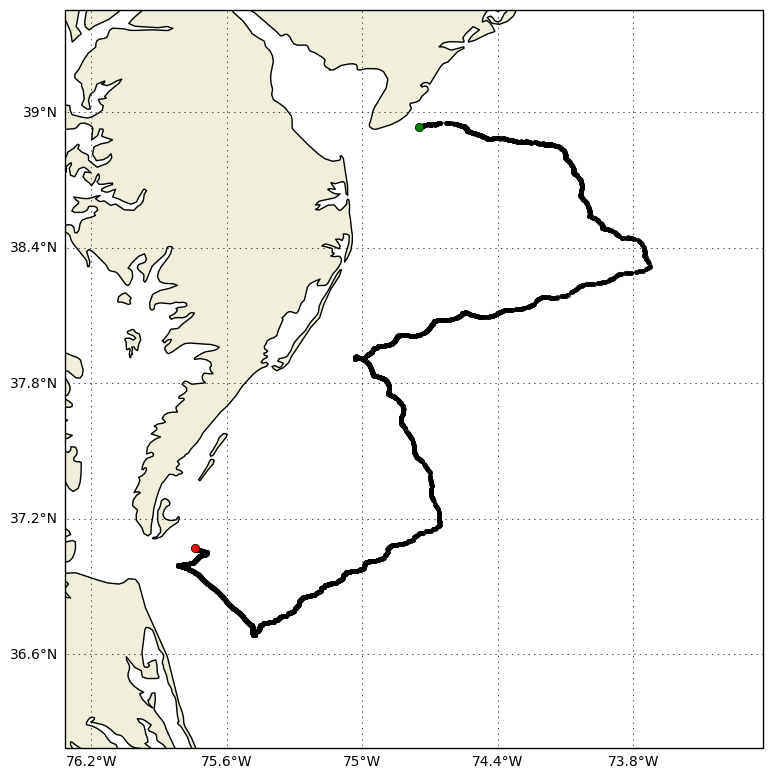

In [3]:
fig, ax = make_map()
ax.plot(x, y, '.-', color='black', alpha=0.75)
ax.plot(x[0], y[0], marker='o', color='green')
ax.plot(x[-1], y[-1], marker='o', color='red')
dx = dy = 0.5
ax.set_extent([x.min()-dx, x.max()+dx, y.min()-dy, y.max()+dy])

### Glider profile data.

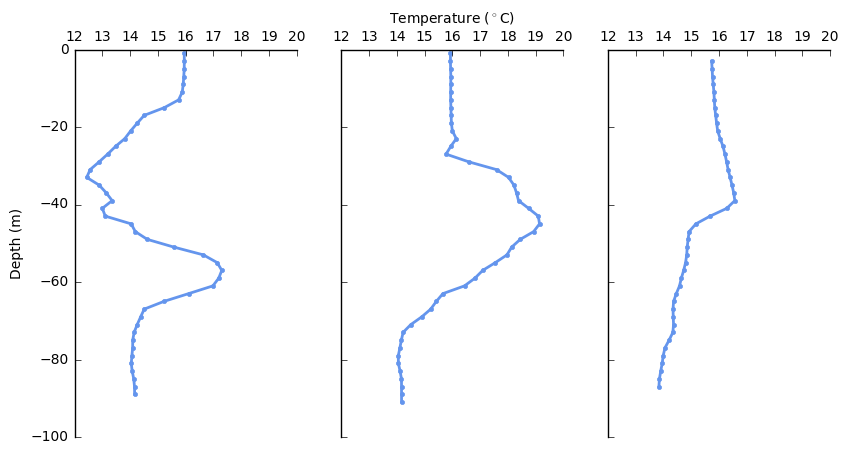

In [4]:
ncols = 3
fig, (ax0, ax1, ax2) = plt.subplots(sharey=True, sharex=True,
                                    ncols=ncols, figsize=(3.25*ncols, 5))

# Some of the deepest profiles.
ax0.plot(temp[732], z, linewidth=2, color='cornflowerblue', marker='.')
ax1.plot(temp[754], z, linewidth=2, color='cornflowerblue', marker='.')
ax2.plot(temp[1785], z, linewidth=2, color='cornflowerblue', marker='.')


def spines(ax):
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')

[spines(ax) for ax in (ax0, ax1, ax2)]

ax0.set_ylabel('Depth (m)')
ax1.set_xlabel(r'Temperature ($^\circ$C)')
ax1.xaxis.set_label_position('top')

### Cross-section of glider data.

In [5]:
%matplotlib inline
import numpy as np
import seawater as sw
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def distance(x, y, units='km'):
    dist, pha = sw.dist(x, y, units=units)
    return np.r_[0, np.cumsum(dist)]


def plot_glider(x, y, z, t, data, cmap=plt.cm.viridis,
                figsize=(9, 3.75), track_inset=False):

    fig, ax = plt.subplots(figsize=figsize)
    dist = distance(x, y, units='km')
    z = np.abs(z)
    dist, z = np.broadcast_arrays(dist[..., np.newaxis], z)
    cs = ax.pcolor(dist, z, data, cmap=cmap, snap=True)
    kw = dict(orientation='vertical', extend='both', shrink=0.65)
    cbar = fig.colorbar(cs, **kw)

    if track_inset:
        axin = inset_axes(ax, width="25%", height="30%", loc=4)
        axin.plot(x, y, 'k.')
        start, end = (x[0], y[0]), (x[-1], y[-1])
        kw = dict(marker='o', linestyle='none')
        axin.plot(*start, color='g', **kw)
        axin.plot(*end, color='r', **kw)
        axin.axis('off')

    ax.invert_yaxis()
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Depth (m)')
    title = '{0:%Y-%m-%d %H:%M:%S} to {1:%Y-%m-%d %H:%M:%S}'.format
    ax.set_title(title(t[0], t[-1]).format(t[0], t[-1]))
    return fig, ax, cbar

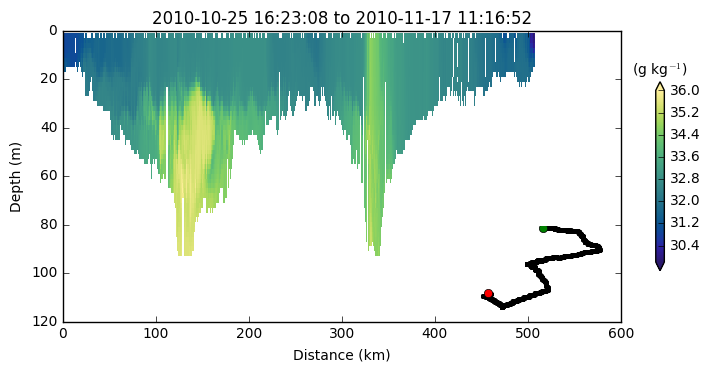

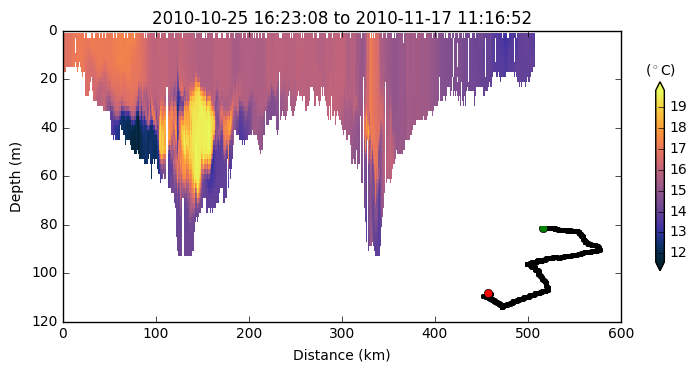

In [6]:
import cmocean

fig, ax, cbar = plot_glider(x, y, z, t, sal,
                            cmap=cmocean.cm.haline, track_inset=True)
cbar.ax.set_xlabel(r'(g kg$^{-1}$)')
cbar.ax.xaxis.set_label_position('top')

fig, ax, cbar = plot_glider(x, y, z, t, temp,
                            cmap=cmocean.cm.thermal, track_inset=True)
cbar.ax.set_xlabel(r'($^\circ$C)')
cbar.ax.xaxis.set_label_position('top')